# Importing GDS files

In Tidy3D, complex structures can be defined or imported from GDSII files via the third-party [gdstk](https://heitzmann.github.io/gdstk/) package. In this tutorial, we will illustrate how to use the package to read a previously saved GDS file and import the structures in a simulation. For a tutorial on how to generate the GDS file used in this example, please refer to [this](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSCreation/) notebook.

<img src="img/splitter.png" alt="Schematic of the directional coupler" width="400"/>

Note that this tutorial requires gdstk, so grab it with `pip install gdstk` before running the tutorial or uncomment the cell line below.

Alternatively, the same layout design can be done using [Photonforge](https://www.flexcompute.com/photonforge/), our photonic design automation tool.

We also provide a comprehensive list of other tutorials such as [how to define boundary conditions](https://www.flexcompute.com/tidy3d/examples/notebooks/BoundaryConditions/), [how to compute the S-matrix of a device](https://www.flexcompute.com/tidy3d/examples/notebooks/SMatrix/), [how to interact with tidy3d's web API](https://www.flexcompute.com/tidy3d/examples/notebooks/WebAPI/), and [how to define self-intersecting polygons](https://www.flexcompute.com/tidy3d/examples/notebooks/SelfIntersectingPolyslab/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
# install gdstk
#!pip install gdstk

# standard python imports
import gdstk
import matplotlib.pyplot as plt
import numpy as np

# tidy3d import
import tidy3d as td

## Loading a GDS file into Tidy3D

To load the geometry from a GDSII file, we use gdstk to load the library and select the cell with the geometry we want.
It is usually easier to create a dictionary of all the cells in the library to verify that we can find the correct one by name:

In [2]:
gds_path = "misc/coupler.gds"

# Load a GDSII library from the file previously created
lib_loaded = gdstk.read_gds(gds_path)

# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))

Cell names: COUPLER, COUPLER_ARM


In this case, we only have the single cell that we created previously, called “COUPLER”, but usually GDSII files hold tens to hundreds of cells, so it is important to find them by name. Getting to the cell we're interested in now is as simple as:

In [3]:
coup_cell_loaded = all_cells["COUPLER"]

print(coup_cell_loaded)

Cell 'COUPLER' with 1 polygons, 0 flexpaths, 0 robustpaths, 2 references, and 0 labels


Note that we need to know the `gds_layer` and `gds_dtype` used to define the GDS cell earlier, so we can load the right components. 

For a simple case, we can iterate through the polygons and inspect the layers and dtypes.

In [4]:
layer_dtype_pairs = set()
for polygon in coup_cell_loaded.polygons:
    layer_dtype_pairs.add((polygon.layer, polygon.datatype))

print("Layer and datatype pairs in polygons:", layer_dtype_pairs)

Layer and datatype pairs in polygons: {(0, 0)}


### Set up Geometries

Then we can construct tidy3d geometries from the GDS cell we just loaded, along with other information such as the axis, sidewall angle, and bounds of the "slab". When loading GDS cell as the cross section of the device, we can tune ``reference_plane`` to set the cross section to lie at ``bottom``, ``middle``, or ``top`` of the generated [Polyslab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html) with respect to the axis. E.g. if ``axis=1``, ``bottom`` refers to the negative side of the y-axis, and ``top`` refers to the positive side of the y-axis. Additionally, we can optionally dilate or erode the cross section by setting `dilation`. A negative `dilation` corresponds to erosion.

We can also define some structural parameters. We consider the sidewall of the device to be slanted, deviating from the vertical sidewall by `sidewall_angle`. Positive `sidewall_angle` values corresponds to a typical fabrication scenario where the base of the device is larger than the top.

In [5]:
# Define waveguide height
wg_height = 0.22
dilation = 0.02

# Define reference plane and sidewall angle
reference_plane = "bottom"
sidewall_angle = np.pi / 6

substrate_geo = td.Geometry.from_gds(
    coup_cell_loaded,
    gds_layer=0,
    gds_dtype=0,
    axis=2,
    slab_bounds=(-4, 0),
    reference_plane=reference_plane,
)

arms_geo = td.Geometry.from_gds(
    coup_cell_loaded,
    gds_layer=1,
    gds_dtype=0,
    axis=2,
    slab_bounds=(0, wg_height),
    sidewall_angle=sidewall_angle,
    dilation=dilation,
    reference_plane=reference_plane,
)

Let's plot the base and the top of the coupler waveguide arms to make sure it looks ok. The base of the device should be larger than the top due to a positive `sidewall_angle`.

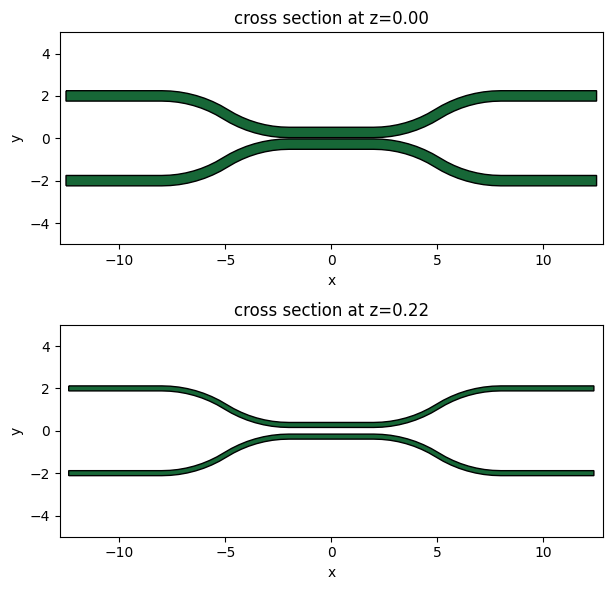

In [6]:
f, ax = plt.subplots(2, 1, figsize=(15, 6), tight_layout=True)
arms_geo.plot(z=0.0, ax=ax[0])
arms_geo.plot(z=wg_height, ax=ax[1])

ax[0].set_ylim(-5, 5)
_ = ax[1].set_ylim(-5, 5)

### Set up Structures

To make use of these new geometries, we need to load them into a `td.Simulation` as `td.Structures` with material properties.

We'll define the substrate and waveguide mediums and then link them up with the Polyslabs.

In [7]:
# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
medium_wg = td.Medium(permittivity=wg_n**2)
medium_sub = td.Medium(permittivity=sub_n**2)

# Substrate
substrate = td.Structure(geometry=substrate_geo, medium=medium_sub)

# Waveguides
arms = td.Structure(geometry=arms_geo, medium=medium_wg)

structures = [substrate, arms]

### Set up Simulation

Now let's set up the rest of the Simulation.

In [8]:
# Spacing between waveguides and PML
pml_spacing = 1.0

# Simulation size
sim_size = list(arms_geo.bounding_box.size)
sim_size[0] -= 4 * pml_spacing
sim_size[1] += 2 * pml_spacing
sim_size[2] = wg_height + 2 * pml_spacing

sim_center = list(arms_geo.bounding_box.center)
sim_center[2] = 0

# grid size in each direction
dl = 0.020

### Initialize and visualize simulation ###
sim = td.Simulation(
    size=sim_size,
    center=sim_center,
    grid_spec=td.GridSpec.uniform(dl=dl),
    structures=structures,
    run_time=2e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

### Plot Simulation Geometry

Let's take a look at the simulation all together with the PolySlabs added. Here the angle of the sidewall deviating from the vertical direction is 30 degree.

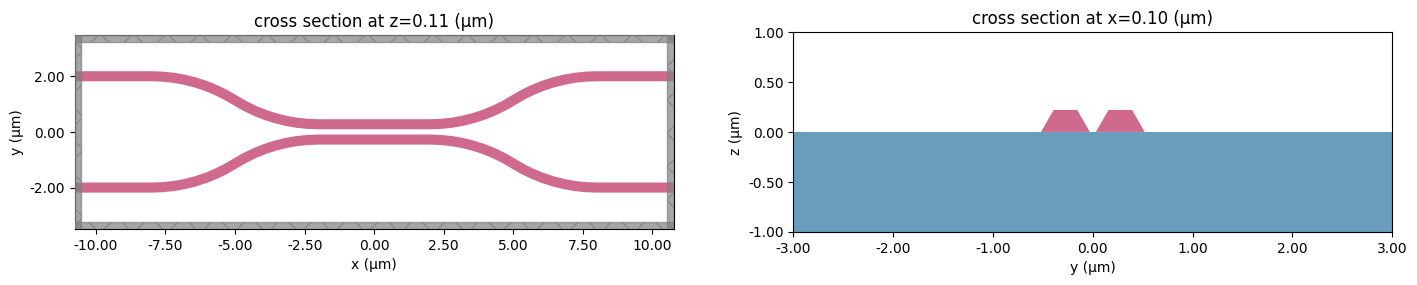

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

sim.plot(z=wg_height / 2, lw=1, edgecolor="k", ax=ax1)
sim.plot(x=0.1, lw=1, edgecolor="k", ax=ax2)

ax2.set_xlim([-3, 3])
_ = ax2.set_ylim([-1, 1])